In [1]:
import re
import os
import torch
import shutil
import warnings

import librosa
import mir_eval
import numpy as np
import torch.nn as nn
import torch.optim as optim

from glob import glob
from tqdm import tqdm
from os.path import join as ospj

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from transcription.globals import BASEPATH
from transcription.globals import SAMPLING_RATE
from transcription.dataloaders import TranscriptionDataset

from transcription.preprocessing import chunkify
from transcription.preprocessing import create_feature_and_annotation

from bs4.builder import XMLParsedAsHTMLWarning
warnings.filterwarnings('ignore', category=XMLParsedAsHTMLWarning)

In [2]:
'''
    If things aren't running, try making the following command to copy the data locally:
        rsync -a /storage/datasets/IDMT-SMT-Drums /ssd/<your-user>/
'''
songnames = os.listdir(ospj(BASEPATH, 'audio/'))
songnames = list(map(lambda filename: filename.split('.')[0], songnames))

has_gpu = torch.cuda.is_available()
device = torch.device('cuda:0' if has_gpu else 'cpu')

print('Running on device:', device)

Running on device: cuda:0


## Chunkifying sequences

#### Creating required folders

In [3]:
if os.path.exists(ospj(BASEPATH, 'chunks')):
    print('Deleting chunks folder...')
    shutil.rmtree(ospj(BASEPATH, 'chunks'))

os.makedirs(ospj(BASEPATH, 'chunks'), exist_ok=True)
os.makedirs(ospj(BASEPATH, 'chunks/train'), exist_ok=True)
os.makedirs(ospj(BASEPATH, 'chunks/validation'), exist_ok=True)

Deleting chunks folder...


#### Splitting data into train and validation

In [4]:
def get_songname_type(songname):
    pattern = re.compile(r'([a-zA-Z]+)')
    matches = pattern.search(songname)
    
    # Returns songname type (RealDrum, WaveDrum or TechnoDrum)
    return matches.group(1)

songname_types = list(map(get_songname_type, songnames))
train_songnames, validation_songnames = train_test_split(songnames, test_size=0.2, random_state=42, stratify=songname_types)

#### Splitting data into multiple chunks

In [5]:
chunkify_hyperparameters = {'window_size': 512, 'hop_length': 32}

print('Splitting train data...')
for songname in tqdm(train_songnames):
    for chunk_id, (spec, annotation) in enumerate(chunkify(songname, **chunkify_hyperparameters)):
        filename = songname + f'_part{chunk_id:03d}'
        filename = ospj(BASEPATH, f'chunks/train/{filename}')
        np.savez(filename, spec=spec, annotation=annotation)
        
print('Splitting validation data...')
for songname in tqdm(validation_songnames):
    for chunk_id, (spec, annotation) in enumerate(chunkify(songname, **chunkify_hyperparameters)):
        filename = songname + f'_part{chunk_id:03d}'
        filename = ospj(BASEPATH, f'chunks/validation/{filename}')
        np.savez(filename, spec=spec, annotation=annotation)

Splitting train data...


100%|██████████| 76/76 [00:06<00:00, 11.30it/s]


Splitting validation data...


100%|██████████| 19/19 [00:01<00:00, 11.92it/s]


## Training Neural Network (*Transformer*)

#### Computing class imbalance weights in training set
- Class weights computed following the suggestions on the [PyTorch's BCEWithLogitsLoss webpage](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss).

In [6]:
total_frames = 0
presence_counter = np.zeros(3)

for filename in tqdm(glob(ospj(BASEPATH, 'chunks/train/*.npz'))):
    data = np.load(filename)
    total_frames += data['annotation'].shape[1]
    presence_counter += (data['annotation'] == 1).sum(axis=1)

pos_weight = torch.from_numpy((total_frames - presence_counter) / presence_counter).to(device)
print('Class weights:', pos_weight)

100%|██████████| 1881/1881 [00:00<00:00, 2256.24it/s]


Class weights: tensor([26.5478, 74.0407, 52.0180], device='cuda:0', dtype=torch.float64)


#### Defining DataLoaders

In [7]:
batch_size = 16

train_dataloader = DataLoader(TranscriptionDataset(is_train=True), batch_size, shuffle=True)
validation_dataloader = DataLoader(TranscriptionDataset(is_train=False), batch_size, shuffle=False)

In [8]:
# Checking if DataLoader output has correct shape
for X, y in train_dataloader:
    break

X.shape, y.shape

(torch.Size([8, 512, 128]), torch.Size([8, 512, 3]))

#### Defining model

In [9]:
class DrumTransformer(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=128, nhead=2, 
                                       dim_feedforward=128*4, batch_first=True),
            num_layers=8,
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, 3)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

In [10]:
model = DrumTransformer().to(device)
model

DrumTransformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, i

In [11]:
sum(p.numel() for p in model.encoder.parameters())

1586176

In [12]:
# Checking if forward is correct
for X, y in train_dataloader:
    X = X.to(device)
    y = y.to(device)
    break
    
outputs = model(X)
assert outputs.shape == y.shape

In [13]:
# Checking if loss function works
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion(outputs, y)

tensor(1.2942, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

#### Running training script

In [14]:
def evaluate(model, validation_dataloader, criterion):
    val_loss = []
    
    model.eval()
    with torch.no_grad():
        for X, y in validation_dataloader:
            X = X.to(device)
            y = y.to(device)
            
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss.append(loss.item())
            
    val_loss = np.mean(val_loss)
    return val_loss        

In [15]:
num_epochs = 500
learning_rate = 0.001

model = DrumTransformer().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

best_validation_loss = np.inf
for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = []
    
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)

        optimizer.zero_grad()
        loss = criterion(outputs, y)
        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    
    train_loss = np.mean(epoch_loss)
    validation_loss = evaluate(model, validation_dataloader, criterion)

    if validation_loss < best_validation_loss:
        print('Saving new best model...')
        best_validation_loss = validation_loss
        torch.save(model.state_dict(), 'transformer_model.ckpt')

    print(f'[epoch {epoch}/{num_epochs}] --> train loss: {train_loss:.5f}, validation loss: {validation_loss:5f}')

Saving new best model...
[epoch 1/500] --> train loss: 1.35593, validation loss: 1.250688
Saving new best model...
[epoch 2/500] --> train loss: 1.35448, validation loss: 1.249887
Saving new best model...
[epoch 3/500] --> train loss: 1.35449, validation loss: 1.249553
[epoch 4/500] --> train loss: 1.35418, validation loss: 1.251123
[epoch 5/500] --> train loss: 1.35436, validation loss: 1.250722
[epoch 6/500] --> train loss: 1.35453, validation loss: 1.250908
[epoch 7/500] --> train loss: 1.35509, validation loss: 1.251570
[epoch 8/500] --> train loss: 1.35391, validation loss: 1.251191
[epoch 9/500] --> train loss: 1.35383, validation loss: 1.250379
[epoch 10/500] --> train loss: 1.35438, validation loss: 1.250412
[epoch 11/500] --> train loss: 1.35488, validation loss: 1.250890
[epoch 12/500] --> train loss: 1.35461, validation loss: 1.250958
[epoch 13/500] --> train loss: 1.35372, validation loss: 1.251025
[epoch 14/500] --> train loss: 1.35521, validation loss: 1.250720
[epoch 15/

#### Checking validation metrics

- We will compute the mean BPM of our whole dataset. This will guide us to tune the ``peak_pick`` algorithm.
- Considering a sixthteen note as being our smallest rhythm figure, our ``peak_pick`` algorithm must have this distance between each note.

In [16]:
from scipy.signal import find_peaks

In [17]:
tempos = []

for filename in tqdm(glob(ospj(BASEPATH, 'audio/*.wav'))):
    wave, sr = librosa.load(filename, sr=SAMPLING_RATE)
    tempos.append(librosa.feature.tempo(y=wave, sr=sr))
    
mean_tempo = np.mean(tempos)
print(f'Mean tempo (BPM): {mean_tempo:.5f}')

100%|██████████| 95/95 [00:11<00:00,  8.51it/s]

Mean tempo (BPM): 115.74726


In [18]:
tempo_of_sixthteen = (60 / mean_tempo) / 8
peak_distance = librosa.time_to_frames(tempo_of_sixthteen, sr=SAMPLING_RATE)

print('Peak distance to be used:', peak_distance)

Peak distance to be used: 5


In [19]:
sigmoid = nn.Sigmoid()
peak_picking_params = {'height': 0.85, 'distance': peak_distance}

best_model = DrumTransformer().to(device)
best_model.load_state_dict(torch.load('transformer_model.ckpt'))

total_size = 0
recall_scores = np.zeros(3)
fmeasure_scores = np.zeros(3)
precision_scores = np.zeros(3)

best_model.eval()
with torch.no_grad():
    for X, y in validation_dataloader:
        X = X.to(device)
        y = y.to(device)

        outputs = best_model(X)
        y_numpy = y.detach().cpu().numpy()
        probabilities = sigmoid(outputs).detach().cpu().numpy()

        total_size += outputs.shape[0]
        for batch_idx in range(outputs.shape[0]):        
            for instrument in range(3):
                reference_onsets = np.where(y_numpy[batch_idx, :, instrument])[0]
                reference_onsets = librosa.frames_to_time(reference_onsets, sr=SAMPLING_RATE)

                estimated_onsets = find_peaks(probabilities[0, :, instrument], **peak_picking_params)[0]
                estimated_onsets = librosa.frames_to_time(estimated_onsets, sr=SAMPLING_RATE)

                if len(reference_onsets) != 0 and len(estimated_onsets) != 0:
                    metrics = mir_eval.onset.evaluate(reference_onsets, estimated_onsets)
                    recall_scores[instrument] += metrics['Recall']
                    fmeasure_scores[instrument] += metrics['F-measure']
                    precision_scores[instrument] += metrics['Precision']

recall_scores /= total_size
fmeasure_scores /= total_size
precision_scores /= total_size

In [20]:
for i, instrument in enumerate(['Hi-Hat', 'Snare Drum', 'Kick Drum']):
    print(f'{instrument} metrics:')
    print(f'  - Mean Recall: {recall_scores[i]:5f}')
    print(f'  - Mean Precision: {precision_scores[i]:5f}')
    print(f'  - Mean F-Measure: {fmeasure_scores[i]:5f}')
    print()
    
print('Overall drumkit metrics:')
print(f'  - Mean Recall: {np.mean(recall_scores):5f}')
print(f'  - Mean Precision: {np.mean(precision_scores[i]):5f}')
print(f'  - Mean F-Measure: {np.mean(fmeasure_scores[i]):5f}')

Hi-Hat metrics:
  - Mean Recall: 0.000000
  - Mean Precision: 0.000000
  - Mean F-Measure: 0.000000

Snare Drum metrics:
  - Mean Recall: 0.000000
  - Mean Precision: 0.000000
  - Mean F-Measure: 0.000000

Kick Drum metrics:
  - Mean Recall: 0.000000
  - Mean Precision: 0.000000
  - Mean F-Measure: 0.000000

Overall drumkit metrics:
  - Mean Recall: 0.000000
  - Mean Precision: 0.000000
  - Mean F-Measure: 0.000000


In [21]:
import matplotlib.pyplot as plt

y_numpy = y.detach().cpu().numpy()

outputs = best_model(X.to(device))
probabilities = sigmoid(outputs).detach().cpu().numpy()

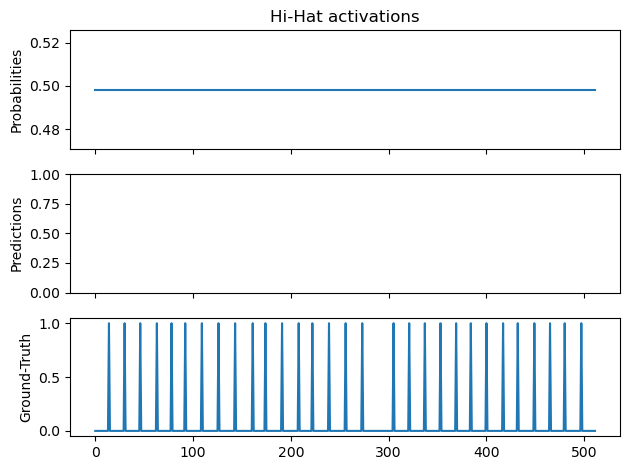

In [22]:
instrument = 0
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].set_title('Hi-Hat activations')
axs[0].set_ylabel('Probabilities')
axs[1].set_ylabel('Predictions')
axs[2].set_ylabel('Ground-Truth')

estimated_onsets = find_peaks(probabilities[0, :, instrument], **peak_picking_params)[0]

axs[0].plot(probabilities[0, :, instrument])

for onset in estimated_onsets:
    axs[1].axvline(onset)
    
axs[2].plot(y_numpy[0, :, instrument])

fig.tight_layout()

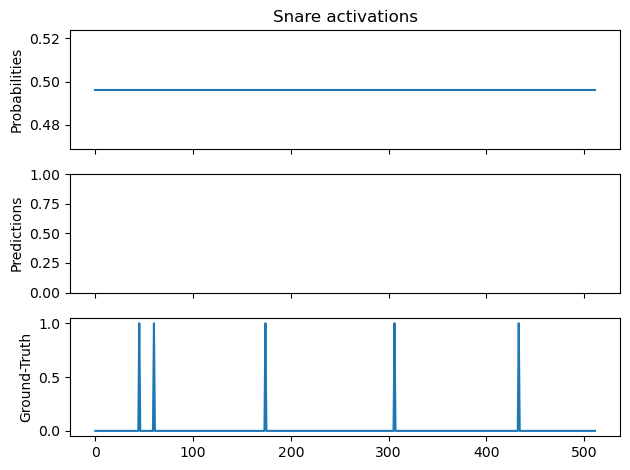

In [23]:
instrument = 1
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].set_title('Snare activations')
axs[0].set_ylabel('Probabilities')
axs[1].set_ylabel('Predictions')
axs[2].set_ylabel('Ground-Truth')

estimated_onsets = find_peaks(probabilities[0, :, instrument], **peak_picking_params)[0]

axs[0].plot(probabilities[0, :, instrument])

for onset in estimated_onsets:
    axs[1].axvline(onset)
    
axs[2].plot(y_numpy[0, :, instrument])

fig.tight_layout()

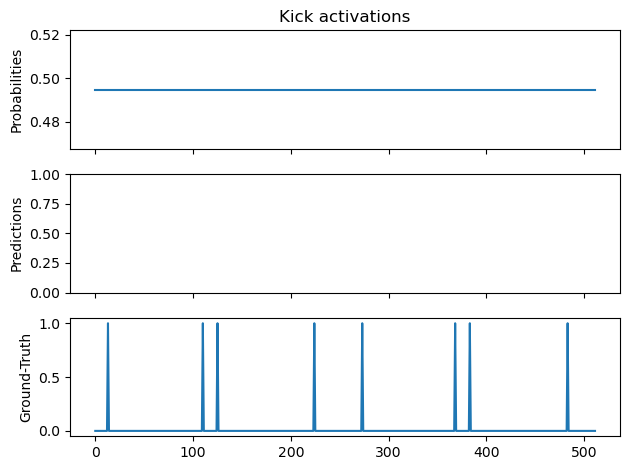

In [24]:
instrument = 2
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].set_title('Kick activations')
axs[0].set_ylabel('Probabilities')
axs[1].set_ylabel('Predictions')
axs[2].set_ylabel('Ground-Truth')

estimated_onsets = find_peaks(probabilities[0, :, instrument], **peak_picking_params)[0]

axs[0].plot(probabilities[0, :, instrument])

for onset in estimated_onsets:
    axs[1].axvline(onset)
    
axs[2].plot(y_numpy[0, :, instrument])

fig.tight_layout()